# Import libraries for analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

#Light GBM
import lightgbm as lgb


from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

PATH = '/media/maria/2TB Monster driv/PrecisionFDA/'


# Read train and test data

In [2]:
train = pd.read_csv(PATH + 'Descriptive/train.csv')
test = pd.read_csv(PATH + 'Descriptive/test.csv')

In [3]:
train.shape

(117626, 945)

In [4]:
train = train.loc[~pd.isna(train['Days_hospitalized'])]
train.shape

(20402, 945)

In [5]:
#Display all database

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [6]:
train['Days_hospitalized'].describe()

count    20402.000000
mean        12.620285
std          4.946833
min          1.000000
25%          8.252257
50%         13.296181
75%         16.329167
max         21.498611
Name: Days_hospitalized, dtype: float64

In [7]:
display_all(train.describe())

DRIVERS  PASSPORT           LAT           LON  HEALTHCARE_EXPENSES  \
count  20402.0   20402.0  20402.000000  20402.000000         2.040200e+04   
mean       1.0       1.0     42.275461    -71.351122         1.087820e+06   
std        0.0       0.0      0.280650      0.593072         5.345845e+05   
min        1.0       1.0     41.242040    -73.490615         5.244150e+03   
25%        1.0       1.0     42.124823    -71.526088         7.035057e+05   
50%        1.0       1.0     42.317243    -71.153259         1.279862e+06   
75%        1.0       1.0     42.455542    -71.021795         1.493375e+06   
max        1.0       1.0     42.896992    -69.927705         3.203008e+06   

       HEALTHCARE_COVERAGE           Age  Allergy to bee venom  \
count         2.040200e+04  20402.000000           2058.000000   
mean          3.044482e+04     58.938241              0.173955   
std           7.369992e+04     17.553300              0.379163   
min           0.000000e+00     21.000000              0.000000   
25%           6.402702e+03     47.000000              0.000000   
50%           1.110707e+04     62.000000              0.000000   
75%           2.087460e+04     74.000000              0.000000   
max           1.557373e+06     84.000000              1.000000   

       Allergy to dairy product  Allergy to eggs  Allergy to fish  \
count               2058.000000      2058.000000      2058.000000   
mean                   0.037901         0.043732         0.167153   
std                    0.191003         0.204547         0.373203   
min                    0.000000         0.000000         0.000000   
25%                    0.000000         0.000000         0.000000   
50%                    0.000000         0.000000         0.000000   
75%                    0.000000         0.000000         0.000000   
max                    1.000000         1.000000         1.000000   

       Allergy to grass pollen  Allergy to mould  Allergy to nut  \
count              2058.000000       2058.000000     2058.000000   
mean                  0.267250          0.397473        0.190962   
std                   0.442631          0.489494        0.393155   
min                   0.000000          0.000000        0.000000   
25%                   0.000000          0.000000        0.000000   
50%                   0.000000          0.000000        0.000000   
75%                   1.000000          1.000000        0.000000   
max                   1.000000          1.000000        1.000000   

       Allergy to peanuts  Allergy to soya  Allergy to tree pollen  \
count         2058.000000      2058.000000             2058.000000   
mean             0.197765         0.016035                0.264334   
std              0.398411         0.125640                0.441085   
min              0.000000         0.000000                0.000000   
25%              0.000000         0.000000                0.000000   
50%              0.000000         0.000000                0.000000   
75%              0.000000         0.000000                1.000000   
max              1.000000         1.000000                1.000000   

       Allergy to wheat  Dander (animal) allergy  House dust mite allergy  \
count       2058.000000              2058.000000              2058.000000   
mean           0.041302                 0.351798                 0.265792   
std            0.199037                 0.477647                 0.441861   
min            0.000000                 0.000000                 0.000000   
25%            0.000000                 0.000000                 0.000000   
50%            0.000000                 0.000000                 0.000000   
75%            0.000000                 1.000000                 1.000000   
max            1.000000                 1.000000                 1.000000   

       Latex allergy  Shellfish allergy  Agreeing on diabetes care plan  \
count    2058.000000        2058.000000                    19399.000000   
mean    

# Hyperparameters for LightGBM

In [8]:
seed = 42
#Using the parameters from a similar project on ICU mortality 

param = {'num_leaves': 15,
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'colsample_bytree':0.6189140385454879,
        'max_child_samples': 254,
        'min_child_weight': 0.001,
        'subsample': 0.7098267979279573,
        'reg_alpha': 5, 
        'reg_lambda': 1, 
        'scale_pos_weight': 2,
        'save_binary': True,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'regression',  #tweedie
        'verbose': 1,
        'metric': {'rmse'},
        'is_unbalance': False, 
        'boost_from_average': True,
        'extra_trees': True
    }

In [9]:
##concatenate train and test to get dummies and not get error
#train['is_train'] = 1
#test['is_train'] = 0
#train_test = pd.concat([train, test], axis = 0)
#display_all(train_test.head())

In [10]:
train.drop(columns=['COVID_Status', 'Hospitalized', 'Ventilator', 'ICU', 'Id', 'Days_ICU', 'Death'], inplace=True)  

In [11]:
predictors_int = list(train.columns)

In [12]:
cat_names = ['MARITAL', 'RACE', 'ETHNICITY',
             'GENDER', 'COUNTY', 'PLACE_BIRTH']

In [13]:
predictors_int.remove('MARITAL')
predictors_int.remove('RACE')
predictors_int.remove('ETHNICITY')
predictors_int.remove('GENDER')
predictors_int.remove('COUNTY')
predictors_int.remove('PLACE_BIRTH')


In [14]:
#Concatenate train and test to not get error when creating dummies or missing data
train['is_train'] = 1
test['is_train'] = 0
train_test = pd.concat([train, test], axis = 0, sort=False)


In [15]:
train_test.shape

(49894, 940)

In [16]:
#one-hot encoding of categorical variables
train_test = pd.get_dummies(train_test, columns = cat_names, dummy_na=True)

In [17]:
train = train_test.loc[train_test.is_train==1]
test = train_test.loc[train_test.is_train==0]

In [18]:
train.shape

(20402, 997)

In [19]:
train = train.drop(columns=['is_train'])

In [20]:
test = test.drop(columns=['is_train', 'Id'])

In [21]:
predictors = list(train.columns)
predictors.remove('Days_hospitalized')
predictors.remove('Id')

# LightGBM Model

In [22]:

nfold = 5
target = 'Days_hospitalized' 
skf = KFold(n_splits=nfold, shuffle=True, random_state=2019)

oof = np.zeros(len(train))
predictions = np.zeros(len(test))

In [23]:
len(oof)

20402

In [24]:

i = 1

for train_index, valid_index in skf.split(train, train.Days_hospitalized.values):
    print("\nfold {}".format(i))
    print(len(valid_index))
    
    #Train data
    t=train.iloc[train_index]
        
    xg_train = lgb.Dataset(t[predictors].values,
                           label=t[target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )
    
    xg_valid = lgb.Dataset(train.iloc[valid_index][predictors].values,
                           label=train.iloc[valid_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )   

    num_rounds = 2000
    clf = lgb.train(param, xg_train, num_rounds, valid_sets = [xg_train, xg_valid], 
                    verbose_eval=2000, early_stopping_rounds = 100) #1000
    oof[valid_index] = clf.predict(train.iloc[valid_index][predictors].values, num_iteration=clf.best_iteration) 
    #save models
    clf.save_model('lgb_classifier_fold{}.txt'.format(i), num_iteration=clf.best_iteration) 
    #to read model model = lgb.Booster(model_file='lgb_classifier.txt')
    predictions += clf.predict(test[predictors], num_iteration=clf.best_iteration) / nfold
    i = i + 1



fold 1
4081
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[536]	training's rmse: 4.30236	valid_1's rmse: 4.45022

fold 2
4081
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[590]	training's rmse: 4.29568	valid_1's rmse: 4.4029

fold 3
4080
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[527]	training's rmse: 4.28319	valid_1's rmse: 4.5269

fold 4
4080
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[931]	training's rmse: 4.19634	valid_1's rmse: 4.50705

fold 5
4080
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[758]	training's rmse: 4.24967	valid_1's rmse: 4.4307


# Metrics Analysis

In [25]:
graph = lgb.create_tree_digraph(clf)
graph.render(view=True)

'Digraph.gv.pdf'

In [26]:
#print("\n\nCV AUC: {:<0.5f}".format(metrics.roc_auc_score(train.Death.values.astype(bool), oof)))
#print("\n\nCV log loss: {:<0.5f}".format(metrics.log_loss(train.Death.values.astype(bool), oof)))
#print("\n\nCV Gini: {:<0.5f}".format(2 * metrics.roc_auc_score(train.Death.values.astype(bool), oof) -1))

# Save Predictions and OOF

In [27]:
sub_df = pd.read_csv(PATH + 'Descriptive/test.csv')
sub_df["Days_hospitalized"] = predictions


In [28]:
sub_df[['Id', 'Days_hospitalized']].to_csv("lightgbm_Hospitalized.csv", index=False, line_terminator='\n', header=False)


In [29]:
np.mean(predictions)

12.723031033661478

In [30]:
#save oof

train = pd.read_csv(PATH + 'Descriptive/train.csv')
train = train.loc[~pd.isna(train['Days_hospitalized'])]
oof_df = train[["Id", "Days_hospitalized"]]


In [31]:
len(oof)

20402

In [32]:
train.shape

(20402, 945)

In [33]:
oof_df.loc[:,"LGBM"] = oof
oof_df[:10]

/home/maria/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/maria/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Id  Days_hospitalized       LGBM
4   26e5d262-6cdc-4274-a5cd-d7fd439e35f9          17.303472  14.232476
5   90031c21-e8a4-416e-b60b-23e871ee62dc          20.324306  14.132582
12  c58ae02e-235e-4db2-a9c3-6926e9c0c5fa           4.122917  12.516527
13  0e07d4b4-8c0a-4cd0-a439-8f3b96ab884d          20.320833  14.525776
30  ef272f3c-6cbd-401c-97b5-db5de666b6e5          20.027778  14.875194
32  8173a76b-72b9-4661-bee3-fb970b46c466          19.369444  14.194884
38  52e1f151-e98b-4163-a250-5e7d5c6ff813           7.194444  13.645225
45  dc88a3e8-716c-42b0-8953-08727552c9ab          13.059722  13.001797
47  850b2ad9-ebf2-4f26-bd12-d041791ec3e2          19.386111   9.559668
48  223e4aec-a073-4599-8efe-a18af14610fa          12.120139  14.445182

In [34]:
oof_df.to_csv("Ooflightgbm.csv", index=False)

# Explainability

In [35]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline

In [36]:
#https://eli5.readthedocs.io/en/latest/tutorials/xgboost-titanic.html#simple-xgboost-classifier

In [37]:
import seaborn as sns

In [38]:
imp_df = pd.DataFrame()
imp_df['feature'] = predictors
imp_df['gain']  = clf.feature_importance(importance_type='gain')
imp_df['split'] = clf.feature_importance(importance_type='split')

In [39]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

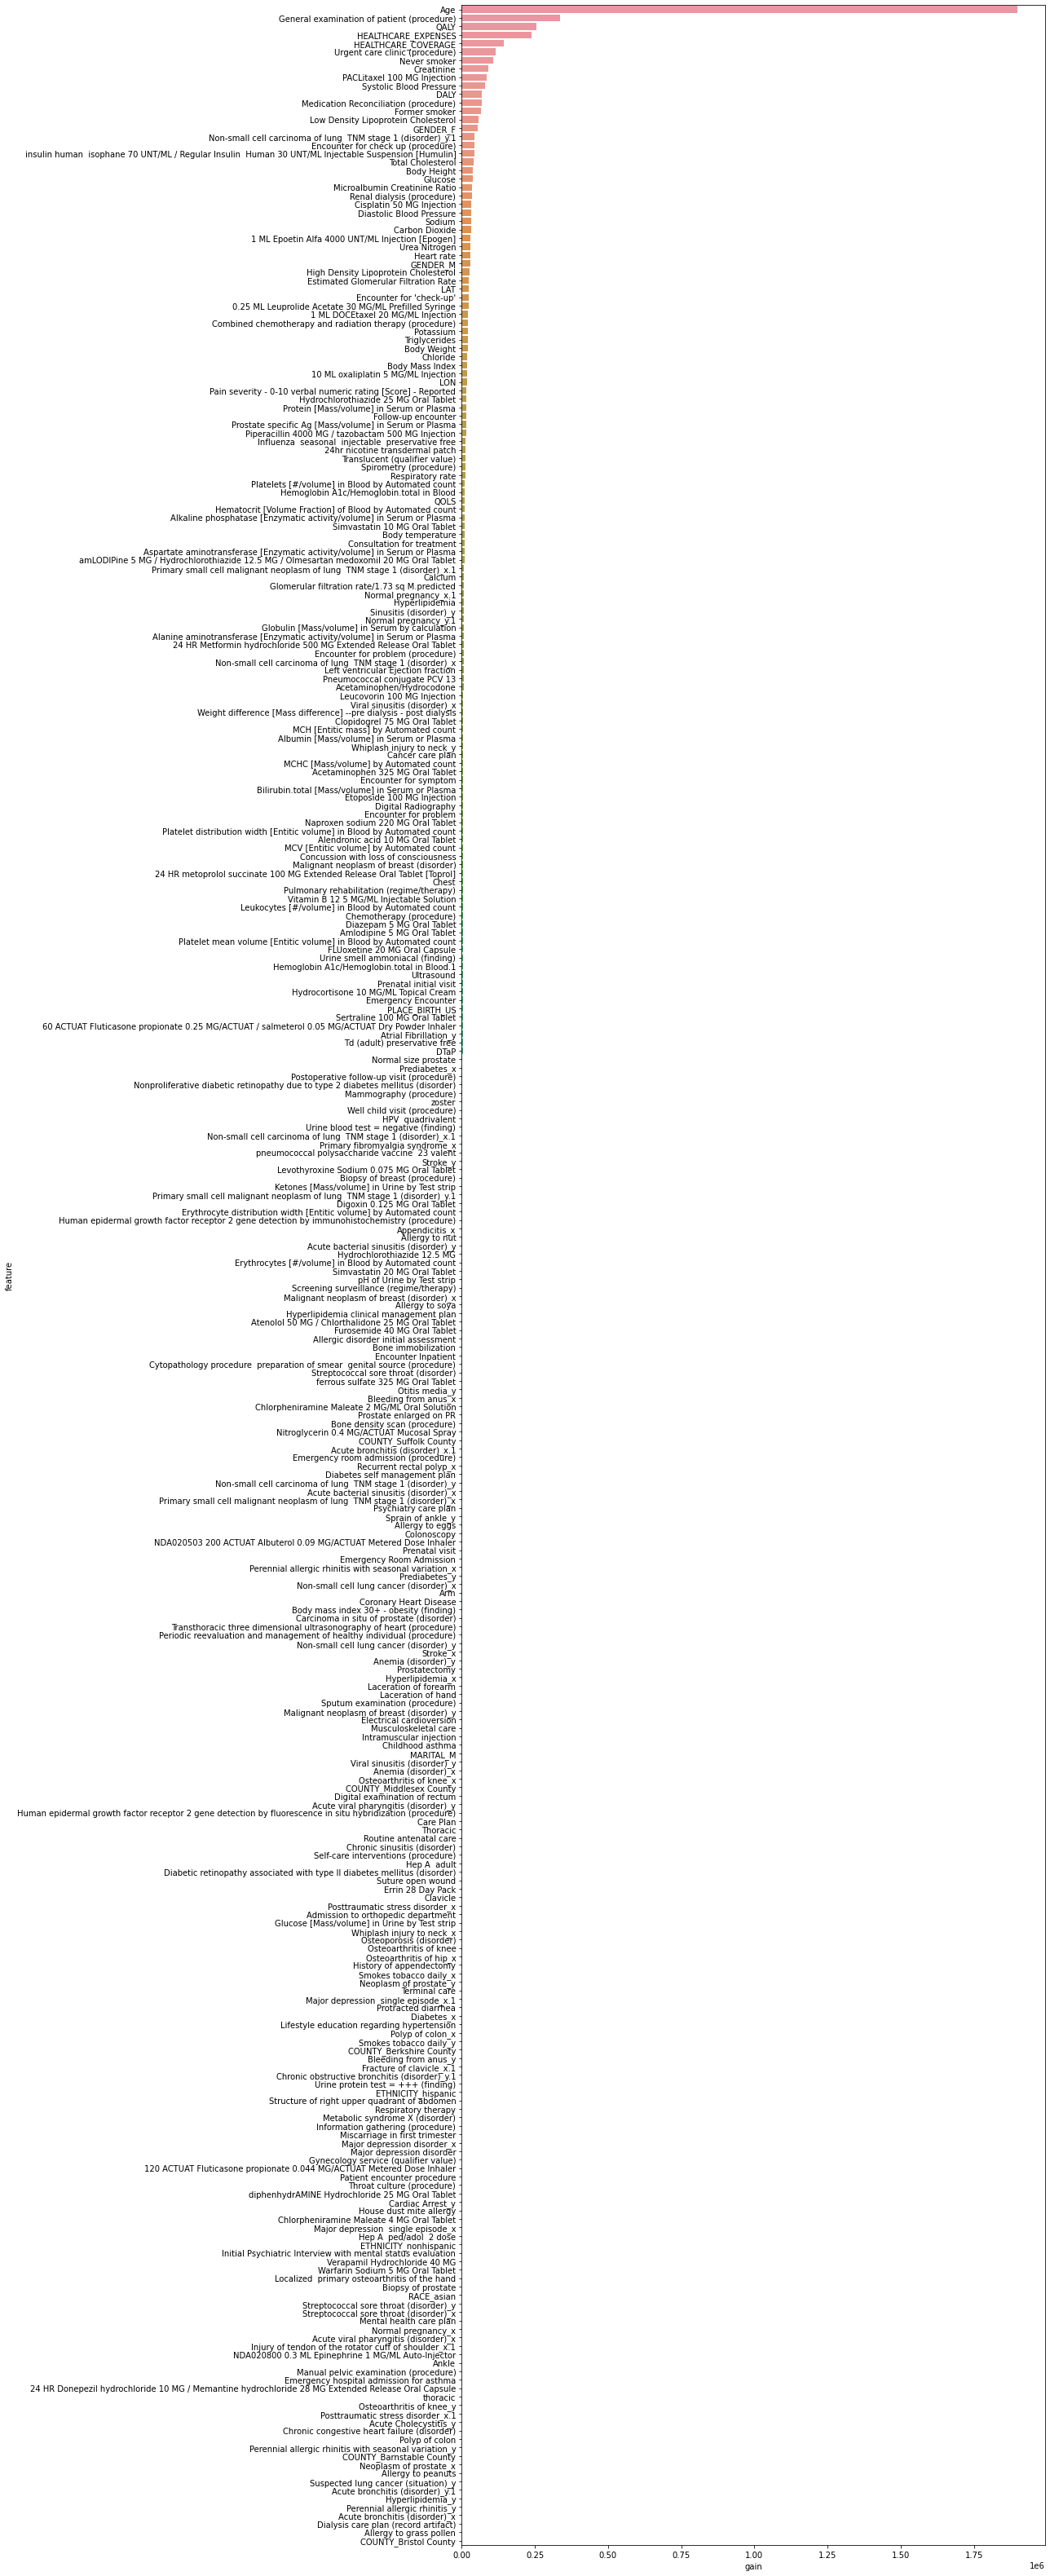

In [40]:
plot_importances(imp_df)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


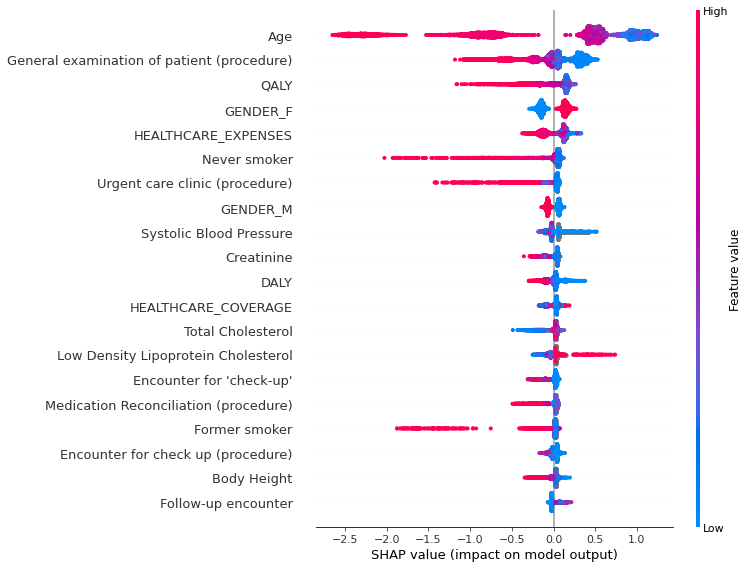

In [41]:
import shap
explainer   =  shap.TreeExplainer(clf)
shap_values = explainer.shap_values(t[predictors].iloc[:8000,:])
shap.summary_plot(shap_values, t[predictors].iloc[:8000,:])

In [42]:
shap.initjs()
# visualize the training set predictions
# SHAP plots for all the data is very slow, so we'll only do it for a sample. Taking the head instead of a random sample is dangerous! 
i = 1

shap.force_plot(explainer.expected_value, shap_values[i,:], t[predictors].iloc[i,:])

In [43]:
i = 0

shap.force_plot(explainer.expected_value, shap_values[i,:], t[predictors].iloc[i,:])

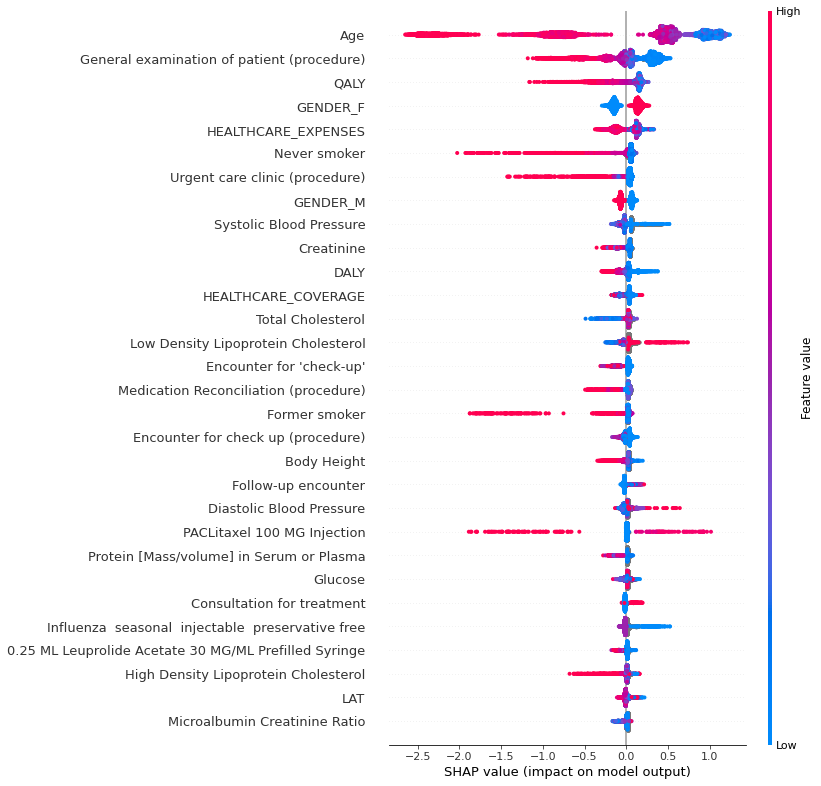

In [44]:
# summarize the effects of top features
shap.summary_plot(shap_values, t[predictors].iloc[:8000,:], max_display=30)

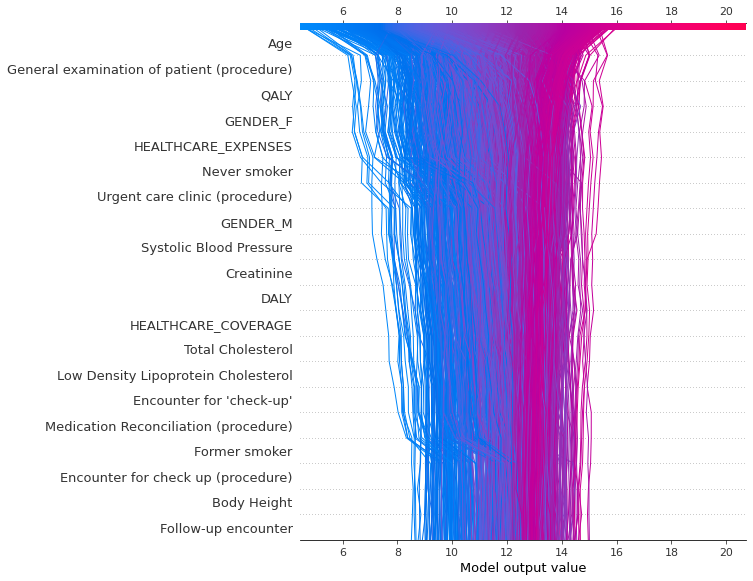

In [45]:
shap.decision_plot(explainer.expected_value, shap_values, predictors, ignore_warnings=True,
                  legend_labels=None)

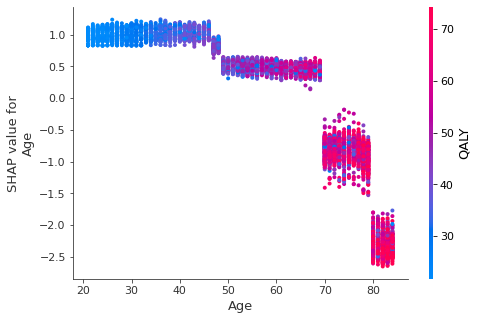

In [46]:
shap.dependence_plot('Age', shap_values, t[predictors].iloc[:8000,:], interaction_index='QALY')

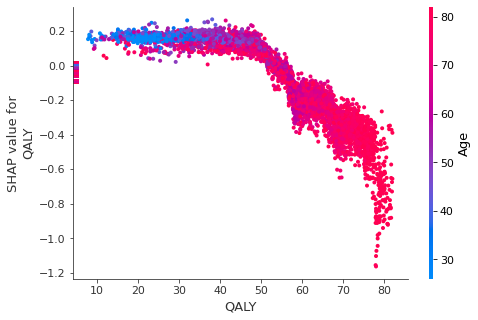

In [47]:
shap.dependence_plot('QALY', shap_values, t[predictors].iloc[:8000,:], interaction_index='Age')

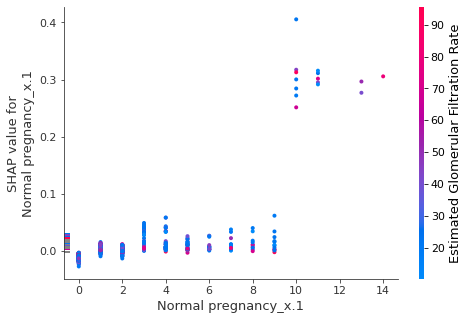

In [48]:
shap.dependence_plot('Normal pregnancy_x.1', shap_values, t[predictors].iloc[:8000,:])